In [21]:
%load_ext autoreload
%autoreload 2

In [27]:
import akantu as aka
import numpy as np
import matplotlib.pyplot as plt
from contact_mechanics_internodes import ContactMechanicsInternodes

In [28]:
mesh_file = 'mesh/hertzian2d.msh'
material_file = 'material/material.dat'
spatial_dimension = 2
aka.parseInput(material_file)

mesh = aka.Mesh(spatial_dimension)
mesh.read(mesh_file)

model = aka.SolidMechanicsModel(mesh)
model.initFull(_analysis_method=aka._implicit_dynamic)

model.applyBC(aka.FixedValue(0., aka._x), 'primary_fixed')
model.applyBC(aka.FixedValue(0., aka._y), 'primary_fixed')
model.applyBC(aka.FixedValue(0., aka._x), 'secondary_fixed')
model.applyBC(aka.FixedValue(-0.1, aka._y), 'secondary_fixed')

nodes_top = mesh.getElementGroup('secondary_fixed').getNodeGroup().getNodes().ravel()
displacements = np.zeros((mesh.getNbNodes(), spatial_dimension))
displacements[nodes_top, 1] = -0.1
displacements = displacements.ravel()

internodes_model = ContactMechanicsInternodes(spatial_dimension, mesh, model, 'primary_candidate', 'secondary_candidate')

f_free = model.getExternalForce().ravel()
f_free = f_free[internodes_model.dofs_free]

In [29]:
def plot_mesh(positions, triangle_indices, nodes_interface=None, nodes_interpenetrating=None, nodes_tension=None):
    plt.figure()
    plt.triplot(positions[:, 0], positions[:, 1], triangle_indices)
    if nodes_interface is not None:
        plt.scatter(positions[nodes_interface, 0], positions[nodes_interface, 1], color="blue")
    if nodes_interpenetrating is not None and nodes_tension is not None:
        plt.scatter(positions[nodes_interpenetrating, 0], positions[nodes_interpenetrating, 1], color="red")
        plt.scatter(positions[nodes_tension, 0], positions[nodes_tension, 1], color="green")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('scaled')
    plt.show()

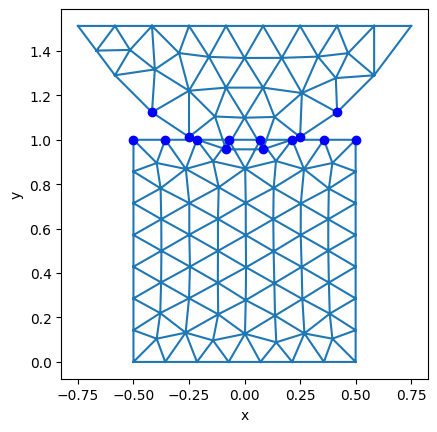

----> Starting iteration 1 <----
Interpenetrating nodes:  []
Nodes in tension:  [ 2  3  6 11 26 31]


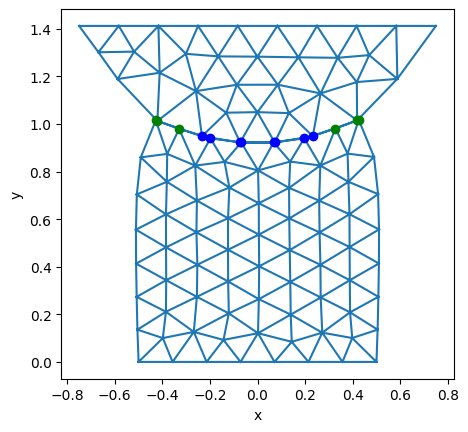

----> Starting iteration 2 <----
Interpenetrating nodes:  []
Nodes in tension:  []


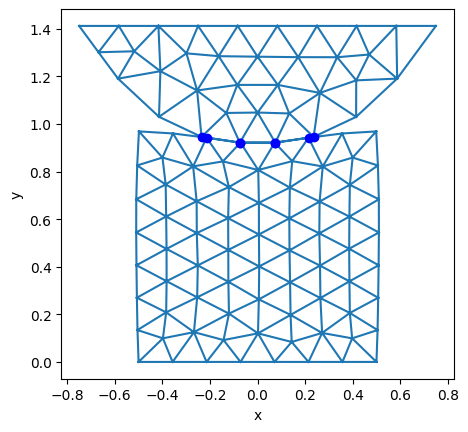


successfully converged in 2 iterations


In [30]:
# Plot initial configuration
nodes_interface = np.union1d(internodes_model.nodes_interface_primary, internodes_model.nodes_interface_secondary)
plot_mesh(internodes_model.mesh.getNodes(), internodes_model.mesh.getConnectivity(aka._triangle_3), nodes_interface)

for i in range(10):
    print("----> Starting iteration", i+1, "<----")

    nodes_interface_primary_old = internodes_model.nodes_interface_primary
    nodes_interface_secondary_old = internodes_model.nodes_interface_secondary

    # Find the interface nodes
    internodes_model.find_interface_nodes()

    # Assemble model
    internodes_model.assemble_interpolation_matrices()
    internodes_model.assemble_stiffness_matrix()
    internodes_model.assemble_interface_mass_matrices()
    internodes_model.assemble_B_matrices()
    internodes_model.assemble_internodes_matrix()
    internodes_model.assemble_force_term(f_free, displacements)

    # Solve model
    positions_new, displacements, lambdas = internodes_model.solve_direct(displacements)

    # Update the interface nodes and check if it converged
    converged = internodes_model.update_interface(positions_new, lambdas)

    nodes_interface = np.union1d(internodes_model.nodes_interface_primary, internodes_model.nodes_interface_secondary)
    nodes_interpenetrating = np.union1d(
        np.setdiff1d(internodes_model.nodes_interface_primary, nodes_interface_primary_old),
        np.setdiff1d(internodes_model.nodes_interface_secondary, nodes_interface_secondary_old))
    nodes_tension = np.union1d(
        np.setdiff1d(nodes_interface_primary_old, internodes_model.nodes_interface_primary),
        np.setdiff1d(nodes_interface_secondary_old, internodes_model.nodes_interface_secondary))
    print("Interpenetrating nodes: ", nodes_interpenetrating)
    print("Nodes in tension: ", nodes_tension)

    # Plot the obtained solution
    plot_mesh(positions_new, internodes_model.mesh.getConnectivity(aka._triangle_3), nodes_interface, nodes_interpenetrating, nodes_tension)
    
    if converged:
        print('\nsuccessfully converged in', i+1, 'iterations')
        break